# Overview
- とりあえずどんなデータか見てみる

# Import Libraries

- pydicom：dicom image fileの読み書き用ぱっけーじ
- pydicomをimportする前に、gcdmをインストールする必要がある。
    - 理由：jpeg圧縮ファイルの操作に必要なため
    詳しくは(公式ドキュメント参照)[https://pydicom.github.io/pydicom/stable/tutorials/installation.html]

In [5]:
!wget 'https://anaconda.org/conda-forge/gdcm/2.8.9/download/linux-64/gdcm-2.8.9-py37h500ead1_1.tar.bz2' -q
!conda install 'gdcm-2.8.9-py37h500ead1_1.tar.bz2' -c conda-forge -y


######################################################################## | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import matplotlib
import cv2
import ast
import warnings
warnings.filterwarnings('ignore')

import pydicom as dicom


## Step 2. Load Data

In [11]:
path = '../kaggle/input/siim-covid19-detection/'

In [12]:
os.listdir(path)

['sample_submission.csv',
 'test',
 'train',
 'train_image_level.csv',
 'train_study_level.csv']

In [14]:
train_image = pd.read_csv(path+'train_image_level.csv')
train_study = pd.read_csv(path+'train_study_level.csv')
sample_submission = pd.read_csv(path+'sample_submission.csv')

In [15]:
len(sample_submission)

2477

テストデータはこんくらい。多いのか少ないのか。

In [17]:
train_image.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [19]:
train_study.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


## Step 3. Read DCM File

### 3-a. explore path with python code

In [20]:
temp = train_image.loc[0, 'StudyInstanceUID']
temp

'5776db0cec75'

In [21]:
temp_depth2 = os.listdir(path+'train/'+temp)
temp_depth2[0]

'81456c9c5423'

In [25]:
temp_train_path = path+'train/'+temp+'/'+temp_depth2[0]
temp_train_path

'../kaggle/input/siim-covid19-detection/train/5776db0cec75/81456c9c5423'

画像へのパス

In [27]:
os.listdir('../kaggle/input/siim-covid19-detection/train/5776db0cec75/81456c9c5423')  

['000a312787f2.dcm']

In [28]:
train_image.loc[0, 'id']

'000a312787f2_image'

### 3-b. make image extractor(function)

In [29]:
def extraction(i):
    path_train = path + 'train/' + train_image.loc[i, 'StudyInstanceUID']
    last_folder_in_path = os.listdir(path_train)[0]
    path_train = path_train + '/{}/'.format(last_folder_in_path)
    img_id = train_image.loc[i, 'id'].replace('_image','.dcm')
    print(img_id)
    data_file = dicom.dcmread(path_train+img_id)
    img = data_file.pixel_array
    return img

## Step 4. Show Sample Image

### 4-a. Explore Image Data with python code

In [30]:
idx=3

sample_img = extraction(idx)

001398f4ff4f.dcm


In [31]:
sample_img

array([[ 489, 1013, 1225, ..., 4095, 4095, 3517],
       [ 749,  798, 1013, ..., 4095, 4095, 3780],
       [1002,  974,  946, ..., 4095, 4095, 4019],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=uint16)

In [32]:
sample_img.shape

(3520, 4280)

### 4-b. check position to draw box

In [33]:
train_image.loc[0, 'boxes']

"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]"

In [34]:
boxes = ast.literal_eval(train_image.loc[0, 'boxes'])
boxes

[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292},
 {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]

astを使うとpythonのリテラルとして文字列を認識する。都合よくDict型ではいってた。

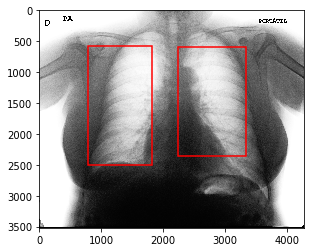

In [35]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
for box in boxes:
    p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                      box['width'], box['height'],
                                      ec='r', fc='none', lw=1.5)
    ax.add_patch(p)
ax.imshow(sample_img, cmap='gray')
plt.show()


## Step 5. Show Multiple Images

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()

for row in range(9):
    img = extraction(row)
    # if (nan == nan)
    # False
    if (train_image.loc[row,'boxes'] == train_image.loc[row,'boxes']):
        boxes = ast.literal_eval(train_image.loc[row,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                              box['width'], box['height'],
                                              ec='r', fc='none', lw=2.
                                            )
            axes[row].add_patch(p)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_image.loc[row, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])

## Step 6. Feature Engineering I

In [ ]:
train_image

### 6-a. Count Opacity in Image

In [ ]:
OpacityCount = train_image['label'].str.count('opacity')
OpacityCount

In [ ]:
train_image['OpacityCount'] = OpacityCount.values

In [ ]:
train_image

In [ ]:
train_image['id'].isnull().sum()

### 6-b. Simplify 'id' (study)

In [ ]:
id_extract = lambda x : x[0]

In [ ]:
train_study

In [ ]:
train_study['id'].isnull().sum()

In [ ]:
train_study['id'].str.split('_')

In [ ]:
train_study['id'].str.split('_').apply(id_extract)

In [ ]:
train_study['id'] = train_study['id'].str.split('_').apply(id_extract)

In [ ]:
sum(train_study['id'].str.contains(train_image['StudyInstanceUID'][0]))

### 6-c. rename colume 'id' to 'StudyInstanceUID for merge on 'StudyInstanceUID'

In [ ]:
train_study = train_study.rename({'id':'StudyInstanceUID'}, axis=1)

In [ ]:
train_study

In [ ]:
train_df = pd.merge(train_image, train_study, on='StudyInstanceUID')
train_df

### 6-d. Check the Relation between 'OpacityCount' and other Columes in train_study

In [ ]:
train_df['OpacityCount'].value_counts()

In [ ]:
train_df.iloc[:,5:].columns

In [ ]:
i = 5
for col in train_df.iloc[:,5:].columns:
    print('The Count of {} : '.format(col), sum(train_df.iloc[:,i]))
    i += 1

In [ ]:
train_df[train_df['OpacityCount'] == 0]

In [ ]:
OCount = sorted(list(train_df['OpacityCount'].value_counts().index))
print(OCount)

In [ ]:
for count in OCount:
    print('Opacity Count = {}\n------------------------------'.format(count))
    print(train_df[train_df['OpacityCount'] == count].iloc[:,5:].sum())
    print(' ')

### 6-e. Visualize the Relation between 'OpacityCount' and other Columes in train_study

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
for count in OCount:
    Count_Series = train_df[train_df['OpacityCount'] == count].iloc[:,5:].sum()
    fig = plt.figure(figsize=(12,3))
    sns.barplot(x=Count_Series.index, y=Count_Series.values/sum(train_df['OpacityCount']==count))
    plt.title('OpacityCount : {} '.format(count))
    plt.plot();

### 6-f. Check Duplicate Values(One row and Two Appearances)

In [ ]:
sum(train_df['OpacityCount']==1)

In [ ]:
train_df[(train_df['OpacityCount']==1)&(train_df['Indeterminate Appearance'] == 1)]

In [ ]:
train_df[(train_df['OpacityCount']==1)&(train_df['Atypical Appearance'] == 1)]

In [ ]:
train_df[(train_df['OpacityCount']==1)&(train_df['Typical Appearance'] == 1)]

In [ ]:
len(train_df[(train_df['OpacityCount']==1)&(train_df['Indeterminate Appearance'] == 1)]) + len(train_df[(train_df['OpacityCount']==1)&(train_df['Atypical Appearance'] == 1)]) + len(train_df[(train_df['OpacityCount']==1)&(train_df['Typical Appearance'] == 1)])

In [ ]:
sum(train_df['OpacityCount']==1)

In [ ]:
sample_submission

## Step 7. Feature Engineering II

### 7-a. explore data analysis

The number of `StudyInstanceUID` in train_study(original id) is different from the number of `StudyInstanceUID` in train_df(==train_image)

Let's check them

In [ ]:
train_study

In [ ]:
train_image

In [ ]:
train_df

In [ ]:
len(train_df['StudyInstanceUID'])

In [ ]:
len(train_df['StudyInstanceUID'].unique())

### 7-b. Check duplicates in dataset

We can find that No duplicates in train_study(original ID) because the length of unique `StudyInstanceUID` in train_df and the length of train_study's rows are the same

In [ ]:
train_image['StudyInstanceUID'].unique().sort() == train_study['StudyInstanceUID'].unique().sort()

In [ ]:
len(train_image['StudyInstanceUID'].unique())

Naturally, because `train_df` is a merged data frame based on `train_image`, `train_image` has also the same result.

Now, Let's check duplicated images(id)

In [ ]:
train_image[train_image.duplicated(['StudyInstanceUID'])==True]['StudyInstanceUID']

In [ ]:
du_StudyId = train_image[train_image.duplicated(['StudyInstanceUID'])==True]['StudyInstanceUID'].values

In [ ]:
du_images = train_image[train_image['StudyInstanceUID'].isin(du_StudyId)].sort_values(by=['StudyInstanceUID'])
du_images

```
232 original ID
280 duplicate ID
```

- one or more duplicate Image at the same ID

### 7-c. modify some of the code in function that extract image(.dcm)

So, Some of the code(function extraction) needs to be modified to accurately target the image to be extracted.

Duplicate ID - ex. 1 ID(74ba8f2badcb) - 4 Path(in each path, All 4 Images are the same)

In [ ]:
train_df[train_df['StudyInstanceUID'].str.contains('74ba8f2')]

In [ ]:
os.listdir(path + 'train/' + '74ba8f2badcb')

In [ ]:
long_path = path + 'train/' + '74ba8f2badcb/'
for i in os.listdir(long_path):
    print(os.listdir(long_path+i))

In [ ]:
os.listdir('/kaggle/input/siim-covid19-detection/train/ff0879eb20ed/d8a644cc4f93')


Search all paths through a loop and check whether it matches the id value.

In [ ]:
def error_processed_extraction(i):
    long_path = path + 'train/' + train_df.loc[i, 'StudyInstanceUID'] + '/'
    img_id = train_df.loc[i, 'id'].replace('_image','.dcm')
    for dcm in os.listdir(long_path):
        dcm_path = long_path+dcm+'/'
        if img_id == os.listdir(dcm_path)[0]:
            data_file = dicom.dcmread(dcm_path+img_id)
            print('index : {} - DCM File Path :{}'.format(i, dcm_path+img_id))
        else:
            continue
            
    img = data_file.pixel_array
    return img

## 8. Visualize X-ray with bbox

In [ ]:
OpacityType = list(train_df.iloc[:,5:].columns)
OpacityType

In [ ]:
train_df[train_df[OpacityType[0]]==1]

### 8-a. Negative for Pneumonia

In [ ]:
Negative_Idx = list(train_df[train_df[OpacityType[0]]==1].index)
Negative_Idx[:9]

In [ ]:
train_df.iloc[Negative_Idx, :]

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()
row = 0
for idx in Negative_Idx[:9]:
    img = error_processed_extraction(idx)
    # if (nan == nan)
    # False
    if (train_df.loc[idx,'boxes'] == train_df.loc[idx,'boxes']):
        boxes = ast.literal_eval(train_df.loc[idx,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                              box['width'], box['height'],
                                              ec='r', fc='none', lw=2.
                                            )
            axes[row].add_patch(p)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(str(train_df.loc[idx, 'label'].split(' ')[0])+ str(idx))
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1

### 8-b. Typical Appearance

In [ ]:
Typical_Idx = list(train_df[train_df[OpacityType[1]]==1].index)
Typical_Idx[:9]

In [ ]:
train_df.iloc[Typical_Idx, :]

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()
row = 0
for idx in Typical_Idx[:9]:
    img = error_processed_extraction(idx)
    # if (nan == nan)
    # False
    if (train_df.loc[idx,'boxes'] == train_df.loc[idx,'boxes']):
        boxes = ast.literal_eval(train_df.loc[idx,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                              box['width'], box['height'],
                                              ec='r', fc='none', lw=2.
                                            )
            axes[row].add_patch(p)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_df.loc[idx, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1

### 8-c. Indeterminate Appearance

In [ ]:
Indeterminate_Idx = list(train_df[train_df[OpacityType[2]]==1].index)
Indeterminate_Idx[:9]

In [ ]:
train_df.iloc[Indeterminate_Idx, :]

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()
row = 0
for idx in Indeterminate_Idx[:9]:
    img = error_processed_extraction(idx)
    # if (nan == nan)
    # False
    if (train_df.loc[idx,'boxes'] == train_df.loc[idx,'boxes']):
        boxes = ast.literal_eval(train_df.loc[idx,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                              box['width'], box['height'],
                                              ec='b', fc='none', lw=2.
                                            )
            axes[row].add_patch(p)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_df.loc[idx, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1

### 8-d. Atypical Appearance

In [ ]:
Atypical_Idx = list(train_df[train_df[OpacityType[3]]==1].index)
Atypical_Idx[:9]

In [ ]:
train_df.iloc[Atypical_Idx, :]

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()
row = 0
for idx in Atypical_Idx[:9]:
    img = error_processed_extraction(idx)
    # if (nan == nan)
    # False
    if (train_df.loc[idx,'boxes'] == train_df.loc[idx,'boxes']):
        boxes = ast.literal_eval(train_df.loc[idx,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                              box['width'], box['height'],
                                              ec='g', fc='none', lw=2.
                                            )
            axes[row].add_patch(p)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_df.loc[idx, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1

## 9. Feature Engineering III


Outliers detected through above visualizations. let's check them

In [ ]:
train_df[(train_df['OpacityCount']==0) & (train_df['Negative for Pneumonia']!=1)]

**Anomaly 304 rows : label is 'none' but Non Negative for Pneumonia**

### 9-a. anomaly detection

- Cases with no opacity detected but classified as symptomatic

In [ ]:
i=0
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(12,4))
for type in OpacityType[1:]:
    sr = train_df[(train_df['OpacityCount']==0) & (train_df['Negative for Pneumonia']!=1)].loc[:,type].value_counts()
    sns.barplot(x=sr.index, y=sr.values, ax=axes[i])
    axes[i].set_title(type)
    i += 1

In [ ]:
Anom_Count = train_df[(train_df['OpacityCount']==0) & (train_df['Negative for Pneumonia']!=1)][OpacityType[1:]].sum()
Anom_Count

In [ ]:
plt.figure(figsize=(8,4))
sns.barplot(x=Anom_Count.index, y=Anom_Count.values)
plt.title('Count of "label==none"')
plt.show()

### 9-b. Show Outliers in `Typical Appearance`

In [ ]:
train_df[(train_df['OpacityCount']==0) & (train_df['Negative for Pneumonia']!=1) & (train_df['Typical Appearance']==1)].head()

In [ ]:
Outlier_Typical_Idx = list(train_df[(train_df['OpacityCount']==0) & (train_df['Negative for Pneumonia']!=1) & (train_df['Typical Appearance']==1)].index)
Outlier_Typical_Idx[:6]

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()
row = 0
for idx in Outlier_Typical_Idx[:6]:
    img = error_processed_extraction(idx)

    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_df.loc[idx, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1

### 9-c. Show Outliers in `Indeterminate Appearance`

In [ ]:
train_df[(train_df['OpacityCount']==0) & (train_df['Negative for Pneumonia']!=1) & (train_df['Indeterminate Appearance']==1)].head()

In [ ]:
Outlier_Indeterminate_Idx = list(train_df[(train_df['OpacityCount']==0) & (train_df['Negative for Pneumonia']!=1) & (train_df['Indeterminate Appearance']==1)].index)
Outlier_Indeterminate_Idx[:6]

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()
row = 0
for idx in Outlier_Indeterminate_Idx[:6]:
    img = error_processed_extraction(idx)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_df.loc[idx, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1

### 9-d. Show Outliers in `Atypical Appearance`

In [ ]:
train_df[(train_df['OpacityCount']==0) & (train_df['Negative for Pneumonia']!=1) & (train_df['Atypical Appearance']==1)].head()

In [ ]:
Outlier_Atypical_Idx = list(train_df[(train_df['OpacityCount']==0) & (train_df['Negative for Pneumonia']!=1) & (train_df['Atypical Appearance']==1)].index)
Outlier_Atypical_Idx[:6]

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()
row = 0
for idx in Outlier_Atypical_Idx[:6]:
    img = error_processed_extraction(idx)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_df.loc[idx, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1

## Step 10. Image Data Preprocessing

### 10-a. Add image path to a separate column

In [ ]:
for _, row in train_df.iloc[:5].iterrows():
    print(row)

In [ ]:
from glob import glob

In [ ]:
for _, row in train_df.iloc[:5].iterrows():
    image_id = row['id'].split('_')[0]
    study_id = row['StudyInstanceUID']
    img_path = glob(f'{path}/train/{study_id}/*/{image_id}.dcm')
    print(img_path)

In [ ]:
path_list = []
for _, row in train_df.iterrows():
    image_id = row['id'].split('_')[0]
    study_id = row['StudyInstanceUID']
    img_path = glob(f'{path}/train/{study_id}/*/{image_id}.dcm')
    if len(img_path)==1:
        path_list.append(img_path[0])
    else:
        print(img_path)

In [ ]:
len(path_list)

In [ ]:
path_list[:10]

In [ ]:
train_df['Path'] = path_list

All Image path have been saved (6334)

In [ ]:
train_df

We use this dataframe at Part 2. Let's save this to csv file.

In [ ]:
train_df.to_csv('train_df.csv')

### 10-b. Resize the image (uniform to 150x150) and Scale each pixel values (uniform range 1~255)

In [ ]:
data_file = dicom.read_file(path_list[0])

In [ ]:
data_file.pixel_array

In [ ]:
data_file

In [ ]:
data_file.Rows

In [ ]:
data_file.Columns

In [ ]:
# Test function, We don't use this
def extract_img_size(path_list):
    origin_img_heights = []
    origin_img_widths = []
    i = 0
    for path in path_list:
        data_file = dicom.read_file(path)
        origin_img_heights.append(data_file.Rows)
        origin_img_widths.append(data_file.Columns)
        i += 1
        if i % 100 == 0:
            print('{}/{}'.format(i,len(path_list)))
            
    return origin_img_heights, origin_img_widths

In [ ]:
origin_img_heights, origin_img_widths = extract_img_size(path_list[:10])

In [ ]:
origin_img_heights

In [ ]:
origin_img_widths

In [ ]:
# We use this function
import cv2
def extract_resized_and_origin_img_info(path_list):
    img_list = []
    origin_img_heights = []
    origin_img_widths = []
    i = 0
    for path in path_list:
        data_file = dicom.read_file(path)
        img = data_file.pixel_array

            
        origin_img_heights.append(img.shape[0])
        origin_img_widths.append(img.shape[1])

        
        # scailing to 0~255
        img = (img - np.min(img)) / np.max(img)
        img = (img * 255).astype(np.uint8)
        
        # resizing to 4000+ to 150 default
        img = cv2.resize(img, (150,150))
        img_list.append(img)
        img_array = np.array(img_list)
        i += 1
        if i % 100 == 0:
            print('{} / {}'.format(len(img_array),len(path_list)))
    return img_array, origin_img_heights, origin_img_widths

In [ ]:
test_imgs, origin_img_heights2, origin_img_widths2 = extract_resized_and_origin_img_info(path_list[:10])

In [ ]:
test_imgs.shape

In [ ]:
test_imgs[0].shape

In [ ]:
test_imgs[0]

In [ ]:
print('pixel range : ', '{} ~ {}'.format(min(test_imgs[0].reshape(-1)),max(test_imgs[0].reshape(-1))))

In [ ]:
origin_img_heights2

In [ ]:
origin_img_widths2

In [ ]:
print((origin_img_heights == origin_img_heights2), (origin_img_widths == origin_img_widths2))

exactly same result on two function

### 10-c. Calculate the resize ratio(x, y) and Apply the same to the bounding box

In [ ]:
x_scale_list=[]
y_scale_list=[]
if len(origin_img_heights) == len(origin_img_widths):
    for i in range(len(origin_img_heights)):
        x_scale = 150 / origin_img_widths[i]
        x_scale_list.append(x_scale)
        print(i)
        y_scale = 150 / origin_img_heights[i]
        y_scale_list.append(y_scale)

In [ ]:
x_scale_list

In [ ]:
y_scale_list

Before vs after resizing

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()
row = 0
for idx in range(9):
    img = error_processed_extraction(idx)
    # if (nan == nan)
    # False
    if (train_df.loc[idx,'boxes'] == train_df.loc[idx,'boxes']):
        boxes = ast.literal_eval(train_df.loc[idx,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                              box['width'], box['height'],
                                              ec='b', fc='none', lw=2.)
            axes[row].add_patch(p)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_df.loc[idx, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(16,16))
fig.subplots_adjust(hspace=.1, wspace=.05)
axes = axes.ravel()
row = 0
for idx in range(9):
    img = test_imgs[idx]
    # if (nan == nan)
    # False
    if (train_df.loc[idx,'boxes'] == train_df.loc[idx,'boxes']):
        boxes = ast.literal_eval(train_df.loc[idx,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x']*x_scale_list[idx], box['y']*y_scale_list[idx]),
                                              box['width']*x_scale_list[idx], box['height']*y_scale_list[idx],
                                              ec='b', fc='none', lw=2.)
            axes[row].add_patch(p)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_df.loc[idx, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1